# Exercice de test technique Data Science

## Premiere étape : acquisition de la data, et création de data cohérente

A noter : j'ai laissé quelques print commentés au fur et à mesure du notebook, si vous êtes curieux de voir à quoi les dataframes ressemblent après les étapes de leur construction/ nettoyage.

Les imports et la creation des Dataframes grâce aux différents .CSV :

In [1]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
import re

df_ticket = pd.read_csv('ticket_data.csv')
df_providers = pd.read_csv('providers.csv')
df_cities = pd.read_csv('cities.csv')
df_stations = pd.read_csv('stations.csv')

### Avec la data, on va pouvoir ajouter des colonnes avec des data croisées.

il est difficile de gerer de la data avec des foreign keys avec pandas. Je n'utiliserais pas le **"pd.attrs"** pour sa fragilité dans la propagation dans la data.

Dans la cellule suivante, je convertis les données departure_ts et arrival_ts en datetime64 pour obtenir des durées de trajets (en heures, en float) dans la colonne subsequemment crée.

In [2]:
df_ticket['departure_ts'] = pd.to_datetime(df_ticket['departure_ts'], )
df_ticket['arrival_ts'] = pd.to_datetime(df_ticket['arrival_ts'], )
df_ticket['travel_duration'] = round((df_ticket['arrival_ts'] - df_ticket['departure_ts']).dt.total_seconds()/3600, 2)

In [3]:
#######TEST PRINT###########
# print(df_ticket.dtypes)
# print(df_ticket.head(5))

L'accessibilité entre deux données de deux dataframes avec une structure differente est réduite.
Pour rendre la vectorisation possible, et reduire les temps de calculs futurs lors des requetes,
Je rassemble la data dans une dataframe.

Extraire la data grace à des foreigns keys n'est pas quelquechose de couvert correctement par pandas.

Les boucles **for** de la cellule suivante, bien que peu efficaces, permettent l'extraction des données GPS des villes qui concernent le ticket.


In [4]:
## Création de la colonne 'o_city_lat' qui contient les latitudes des villes de départ des trajets

df_ticket['o_city_lat'] = [df_cities.at[np.where(df_cities['id'] == city_id)[0][0], 'latitude'] for city_id in df_ticket['o_city']]

################################################

## Création de la colonne 'd_city_lat' qui contient les latitudes des villes d'arrivée des trajets
    
df_ticket['d_city_lat'] = [df_cities.at[np.where(df_cities['id'] == city_id)[0][0], 'latitude'] for city_id in df_ticket['d_city']]

################################################

## Création de la colonne 'o_city_lon' qui contient les longitudes des villes de départ des trajets
    
df_ticket['o_city_lon'] = [df_cities.at[np.where(df_cities['id'] == city_id)[0][0], 'longitude'] for city_id in df_ticket['o_city']]

################################################

## Création de la colonne 'd_city_lon' qui contient les longitudes des villes d'arrivée des trajets
    
df_ticket['d_city_lon'] = [df_cities.at[np.where(df_cities['id'] == city_id)[0][0], 'longitude'] for city_id in df_ticket['d_city']]

In [5]:
#######TEST PRINT###########
# print(df_ticket.head(5))
# print(df_ticket.dtypes)

Grâce aux colonnes **'o_city_lat', 'o_city_lon' et 'd_city_lat', 'd_city_lon'**, je vais pouvoir obtenir la distance en km entre les villes de depart et d'arrivée d'un trajet.

Je definis la fonction _haversine_ qui permet le calcul des distances avec les coordonnées gps.
Grâce à Numpy, je peux transformer la fonction _haversine_ pour la vectorisation, qui donne une très bonne rapidité d'execution des calculs sur la dataframe.  

In [6]:
def haversine(lat1, lon1, lat2, lon2):

    R = 6372.8
    
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))

    return round(R * c, 2)

haver_vec = np.vectorize(haversine, otypes=[np.float64])

df_ticket['travel_distance'] = haver_vec(df_ticket['o_city_lat'], df_ticket['o_city_lon'], df_ticket['d_city_lat'], df_ticket['d_city_lon'])

Je vais maintenant supprimer les colonnes de latitude et de longitude, qui ont rempli leur office.

In [7]:
df_ticket = df_ticket.drop(columns = ['o_city_lat', 'd_city_lat', 'o_city_lon', 'd_city_lon'], axis = 1)


In [8]:
#######TEST PRINT###########
# print(df_ticket.head(10))
# print(df_providers.head(10))
# print(df_providers.dtypes)

Je vais maintenant ajouter le type de transport pour chaque ticket.

Je vais filtrer les datas des providers pour differencier les providers de bus, train et voiture.
Le filtre est là pour determiner ceux qui proposent la voiture, ceux qui proposent le train, et ceux qui ne proposent ni train ni voiture proposent le bus.

In [9]:

df_train = df_providers.loc[df_providers['transport_type'].str.contains('train', flags=re.I, regex=True)]
df_car = df_providers.loc[df_providers['transport_type'].str.contains('car[a-z]*', flags=re.I, regex=True)]

car_id = list(df_car['id'])
train_id = list(df_train['id'])

# print(train_id, car_id)

##### A noter : un souci dans la forme de la data : 
Les datas dans la colonne **"other_companies"** ne sont pas des sets d'int, ou meme un set tout court. Quand ce n'est pas null, c'est une str! 
Je définis donc une fonction qui va transformer la string de chaque row de la colonne 'other_companies' en un set d'int, tel qu'il nous l'apparaissait visuellement dans le CSV.

De la même maniere la colonne **"middle_stations"** contient des str et non des sets d'int.

In [10]:
def try_to_int(str_to_conv):
    try:
        res = set(map(int, str_to_conv.split(',')))
        return res
    except (AttributeError):
        return np.nan

df_ticket['other_companies'] = df_ticket['other_companies'].str.strip('{}')
df_ticket['other_companies'] = [try_to_int(i) for i in df_ticket['other_companies']]


In [11]:
#######TEST PRINT###########
# print(df_ticket.head(10))

Cependant, des series contenant des listes ou des sets sont difficiles à manipuler.
Les listes et les sets ne sont pas hashables, le seul moyen de traiter ces informations est donc de faire des boucles,
ce qui rallonge les temps de calculs exponentiellement suivant la taille du dataset.



#### A noter:

Pour simplifier, je vais supposer que même s'il y a correspondance dans le ticket, il n'y pas de changement de moyen de transport.
Le type de transport au départ du trajet est donc considéré comme étant le seul type de transport utilisé sur l'ensemble du trajet.


In [12]:
df_ticket['transport_type'] = ''

        
df_ticket.loc[(df_ticket['company'].isin(car_id)), 'transport_type'] = 'car'

df_ticket.loc[(df_ticket['company'].isin(train_id)), 'transport_type'] = 'train'

df_ticket.loc[(~df_ticket['company'].isin(car_id)) & (~df_ticket['company'].isin(train_id)), 'transport_type'] = 'bus'


In [13]:
#######TEST PRINT###########
# print(df_ticket.head(10))

## Deuxieme étape : Extraction des infos intéressantes!

Maintenant que j'ai affiné la data pour la rendre utilisable efficacement, avec l'ajout de data cohérentes et condensées, je vais pouvoir faire des opérations dessus, et réaliser ma mission. (je suis content que mon ordinateur ne se soit pas autodétruit après l'avoir acceptée...)

Avant de se perdre dans l'infinité de possibilités de combinaisons de la data, je vais déjà vous présenter les données intéressantes basiques telles que les présentation par trajet, par moyen de transport, par distance ... même par combinaison de plusieurs critères différents.

Ci-dessous, je crée une dataframe avec les data pertinentes.

In [14]:
df_info_base = df_ticket[['company', 'price_in_cents', 'o_city', 'd_city', 'travel_duration', 'travel_distance', 'transport_type']]


In [15]:
#######TEST PRINT###########
#print(df_info_base.head(10))

**par trajet ->**

    prix min, moyen et max,
    
    durée min, moyenne et max

In [16]:
## Les prix moyens, minimaux et maximaux par trajets, triés du moins cher au plus cher.

df_price_mean = df_info_base.groupby(['o_city', 'd_city']).mean().sort_values('price_in_cents', ascending=True)['price_in_cents']
df_price_min = df_info_base.groupby(['o_city', 'd_city']).min().sort_values('price_in_cents', ascending=True)['price_in_cents']
df_price_max = df_info_base.groupby(['o_city', 'd_city']).max().sort_values('price_in_cents', ascending=True)['price_in_cents']

## Les durées de trajet moyennes, minimales, et maximales par trajets, en heures (float), triés du plus court au plus long

df_duration_mean = df_info_base.groupby(['o_city', 'd_city']).mean().sort_values('travel_duration', ascending=True)['travel_duration']
df_shortest = df_info_base.groupby(['o_city', 'd_city']).min().sort_values('travel_duration', ascending=True)['travel_duration']
df_longuest = df_info_base.groupby(['o_city', 'd_city']).max().sort_values('travel_duration', ascending=True)['travel_duration']


In [17]:
#######TEST PRINT###########
# print(df_price_mean.head(10))
# print(df_price_min.head(10))
# print(df_price_max.head(10))

# print(df_duration_mean.head(10))
# print(df_shortest.head(10))
# print(df_longuest.head(10))

#### A noter :

Il n'y a pas de données sur des trajets entre des villes séparées par plus de 2000km. Je n'ai donc pas crée cette catégorie.


**par moyen de transport ->** (pour chaque catégorie de distance : 0-200km, 201-800km, 800+km)

    prix moyen des transports spécifiques en fonction de la distance,
    
    durée moyenne des transports spécifiques en fonction de la distance


In [18]:
df_to_200km = df_info_base.loc[(df_info_base['travel_distance'] < 201)]
df_to_800km = df_info_base.loc[(df_info_base['travel_distance'] < 801)]
df_past_800km = df_info_base.loc[(df_info_base['travel_distance'] >= 801)]


## Les prix moyens des transports, sur des trajets inferieurs à 201km, du plus cher au plus économique.
df_by_type_price = df_to_200km.groupby(['transport_type']).mean().sort_values('price_in_cents', ascending=False)['price_in_cents']

## Les durées moyennes des transports, sur des trajets inferieurs à 201km, du plus long au plus court.
df_by_type_duration = df_to_200km.groupby(['transport_type']).mean().sort_values('travel_duration', ascending=False)['travel_duration']


## Les prix moyens des transports, sur des trajets entre 201km et 800km, du plus cher au plus économique.
df_by_type_price_800 = df_to_800km.groupby(['transport_type']).mean().sort_values('price_in_cents', ascending=False)['price_in_cents']

## Les durées moyennes des transports, sur des trajets entre 201km et 800km, du plus long au plus court.
df_by_type_duration_800 = df_to_800km.groupby(['transport_type']).mean().sort_values('travel_duration', ascending=False)['travel_duration']


## Les prix moyens des transports, sur des trajets supérieurs à 801km, du plus cher au plus économique.
df_by_type_price_past800 = df_past_800km.groupby(['transport_type']).mean().sort_values('price_in_cents', ascending=False)['price_in_cents']

## Les durées moyennes des transports, sur des trajets supérieurs à 801km, du plus long au plus court.
df_by_type_duration_past800 = df_past_800km.groupby(['transport_type']).mean().sort_values('travel_duration', ascending=False)['travel_duration']


In [19]:
#######TEST PRINT###########
# print(df_by_type_price)
# print(df_by_type_duration)

# print(df_by_type_price_800)
# print(df_by_type_duration_800)

# print(df_by_type_price_past800)
# print(df_by_type_duration_past800)

### Pour rendre un peu plus claires les comparaisons : 

Nous allons faire des graphes!
Pour l'exemple, je vais présenter les infos précédentes (classées par categorie de distance) dans ces graphes.

In [20]:
## Ces dataframes servent surtout à la facilitation de l'écriture
df_200 = df_to_200km.groupby(['transport_type'], as_index=False).mean()
df_800 = df_to_800km.groupby(['transport_type'], as_index=False).mean()
df_1000 = df_past_800km.groupby(['transport_type'], as_index=False).mean()

## Cette dataframe contient les infos pertinentes et leurs moyennes par catégorie de distance
df = pd.concat([df_200, df_800, df_1000])

## Listes des points d'abscisse(distance) par moyen de transport.
x_train = df.loc[df['transport_type'].str.contains('train'), 'travel_distance'].to_list()
x_car = df.loc[df['transport_type'].str.contains('car'), 'travel_distance'].to_list()
x_bus = df.loc[df['transport_type'].str.contains('bus'), 'travel_distance'].to_list()

## Listes des points d'ordonnée(prix) par moyen de transport.
y_train = df.loc[df['transport_type'].str.contains('train'), 'price_in_cents'].to_list()
y_car = df.loc[df['transport_type'].str.contains('car'), 'price_in_cents'].to_list()
y_bus = df.loc[df['transport_type'].str.contains('bus'), 'price_in_cents'].to_list()

## Listes des points d'ordonnée(durée) par moyen de transport.
y_train_t = df.loc[df['transport_type'].str.contains('train'), 'travel_duration'].to_list()
y_car_t = df.loc[df['transport_type'].str.contains('car'), 'travel_duration'].to_list()
y_bus_t = df.loc[df['transport_type'].str.contains('bus'), 'travel_duration'].to_list()


#### Ci-dessous le graphe de comparaison des prix en fonction de la distance

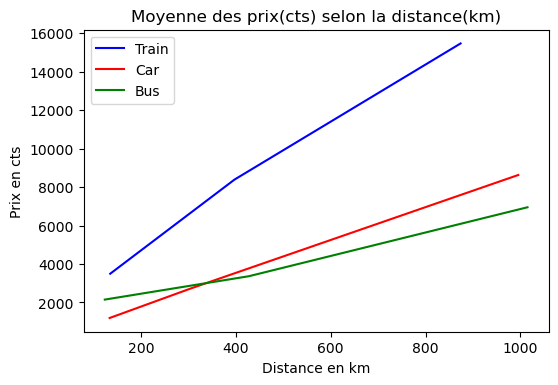

In [21]:
plt.figure(figsize=(6,4), dpi=100)

plt.plot(x_train, y_train, 'b-', label='Train')
plt.plot(x_car, y_car, 'r-', label='Car')
plt.plot(x_bus, y_bus, 'g-', label='Bus')
plt.title('Moyenne des prix(cts) selon la distance(km)')
plt.xlabel('Distance en km')
plt.ylabel('Prix en cts')


plt.legend()
plt.show()

Description : 

On peut voir que le bus est le plus économique pour les destinations les plus lointaines, mais que la voiture reste compétitive pour les destinations proches. Le train, en revanche, est en moyenne plus cher quelque soit la destination.



#### Ci-dessous le graphe de comparaison de la durée du trajet en fonction de la distance

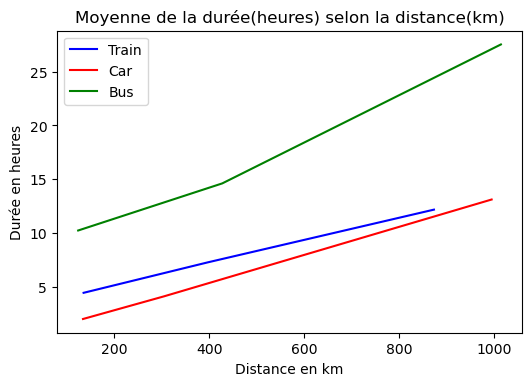

In [22]:
plt.figure(figsize=(6,4), dpi=100)

plt.plot(x_train, y_train_t, 'b', label='Train')
plt.plot(x_car, y_car_t, 'r', label='Car')
plt.plot(x_bus, y_bus_t, 'g', label='Bus')
plt.title('Moyenne de la durée(heures) selon la distance(km)')
plt.xlabel('Distance en km')
plt.ylabel('Durée en heures')

plt.legend()
plt.show()

Description : 

On peut voir que le bus est le moyen de transport le plus lent, quelle que soit la distance jusqu'à destination.

La voiture est le moyen de transport le plus rapide porte à porte.

Le train reste compétitif, mais on peut supposer que les correspondances, parfois longues, augmentent la durée du voyage, expliquant ces durée de trajet plus longues qu'en voiture. On remarque cependant que plus la distance est grande, plus le train devient intéressant par rapport à la voiture. Par manque de données, on ne peut que supposer que le train est plus rapide pour les distances superieures à 1000km ou 1100km.